In [2]:
import tensorflow as tf
import numpy as np

In [3]:
# the input data is 128+64 random binary vectors of dimension 13
# the output for the last 128 times must be zeros vector of dimension 80 with 1 on 16-th position...
def generate():
    X = np.random.randint(0, 2, (128, 128+64, 13))
    X[:, 128:, :] = 0
    Y = np.zeros((128, 128+64, 80))
    Y[:, :, 16] = 1
    return X, Y

In [4]:
# the input data is 128+64 random binary vectors of dimension 13
# the output data has same dimensions; final 128 of vectors must be same as first 128 of input
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.001
training_steps = 2000
batch_size = 128
display_step = 200

# Network Parameters
num_input = 13       # dimension of one input at moment
timesteps = 128+64   # timesteps in one sequence
num_hidden = 70      # num of lstms in first hidden layer
num_hidden2 = 50     # num of lstms in second hidden layer
num_output = 80      # output dimension

# tf graph input
X = tf.placeholder("float", [batch_size, timesteps, num_input])
Y = tf.placeholder("float", [batch_size, timesteps, num_output])

lstm = tf.contrib.rnn.MultiRNNCell([
    tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0),
    tf.contrib.rnn.BasicLSTMCell(num_hidden2, forget_bias=1.0)
])

lstm_outputs, _ = tf.nn.dynamic_rnn(lstm, X, dtype=tf.float32)
lstm_outputs = tf.reshape(lstm_outputs, [batch_size * timesteps, -1])

reads = tf.layers.dense(lstm_outputs, num_output, activation=None)
reads_proba = tf.nn.softmax(reads, dim=1)

reads_proba = tf.reshape(reads_proba, Y.get_shape())
loss_op = tf.reduce_mean(tf.squared_difference(reads_proba[:, 64:], Y[:, 64:]))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,
                                   use_locking=False,
                                   name='Adam')
# optimizing
train_op = tf.contrib.layers.optimize_loss(
                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [5]:
# Start training
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.4  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)

In [6]:
# Run the initializer
sess.run(init)

In [7]:
losses = []
for step in range(training_steps):
    # getting data
    batch_x, batch_y = generate()
    # Run optimization step
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    
    L = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
    losses.append(L)
    
    if step % display_step == 0:
        print(L)
        #L = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
        #print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(L))

print("Optimization Finished!")

0.0123293
6.01422e-06


KeyboardInterrupt: 

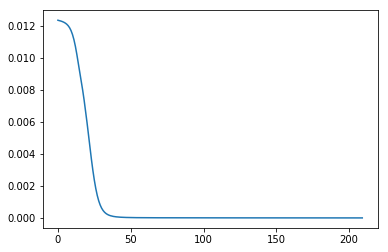

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

In [9]:
train_writer.close()
test_writer.close()

In [10]:
mr = sess.run(read_proba, feed_dict={X: batch_x, Y: batch_y})
mr[0, :]

array([  1.32329958e-09,   2.28147723e-09,   2.26895211e-10,
         2.11227764e-08,   6.51376314e-11,   6.95424491e-12,
         3.74436314e-16,   2.04478056e-06,   4.70638029e-10,
         3.94249255e-08,   1.43008508e-10,   3.22148829e-13,
         6.56150525e-12,   7.15987963e-11,   2.44551428e-11,
         1.34179667e-10,   9.99928117e-01,   1.02201145e-08,
         1.97644345e-09,   2.96105291e-08,   4.03040058e-12,
         3.59931129e-09,   6.62973973e-12,   1.03347485e-12,
         1.98525041e-09,   4.89194063e-09,   7.69428254e-09,
         1.27675119e-11,   3.39276198e-07,   2.97781313e-11,
         1.26282651e-09,   1.51726969e-08,   2.20889884e-08,
         5.09571873e-05,   5.69417083e-12,   2.70955636e-11,
         6.34801031e-11,   1.08647241e-11,   1.00192570e-10,
         1.41224315e-11,   1.41216321e-06,   5.24931135e-15,
         3.15299974e-11,   1.79523604e-16,   2.18823786e-08,
         9.97218488e-11,   9.49899626e-09,   1.39901113e-09,
         2.29028970e-12,

In [11]:
sess.close()